# 2D section inversion:
## Forward Model 1D: Empymod
## Inversion 1D: Pygimli inversion
## No lateral constraints

In [1]:
%matplotlib notebook

In [2]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

Dualem coil configurations:

In [3]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
dip = np.array([0, 90])

Hreceivers = [offsets, offsets*0, 0, 0, 0]
Vreceivers = [offsets, offsets*0, 0, 0, 90]

# Source geometry

Hsource = [0, 0, 0 ,0 , 0]
Vsource = [0, 0, 0, 0, 90]

# Frequency

freq = 9000

In [4]:
# parameters for the synthetic model

nlayer = 40 # number of layer
npos = 20 # number of sampling positions

resistivities = 10
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)
depth = np.linspace(0, 10, nlayer)

# Define a middle resistive layer:
depth1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
depth2 = depth1 + 2 + np.sin(x*np.pi*2) # wave


for i in range(npos):
    for j in range(nlayer):
        if (depth[j] >= depth1[i]) and (depth[j] <= depth2[i]):
            res[i, j] = 50
        

In [5]:

def PlotResistivities(res, npos, nlayer, Modelname):       
    
    fig, ax = plt.subplots()
    pos = ax.imshow(res.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Modelname)
        
    return 

<IPython.core.display.Javascript object>


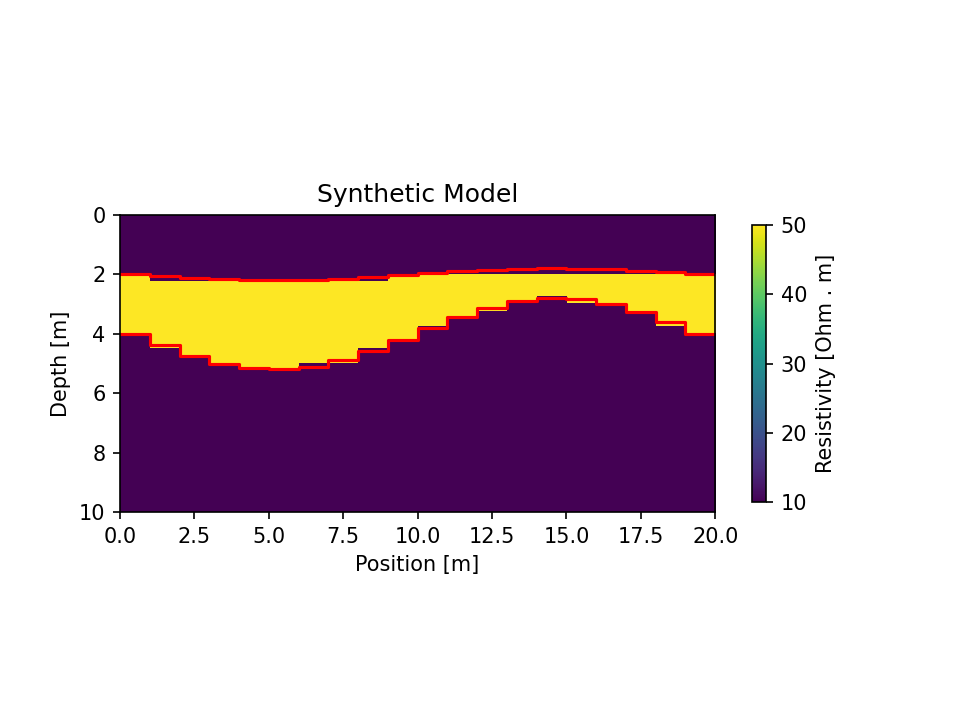

In [6]:
#Plot synthetic model

xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

PlotResistivities(res, npos, nlayer, 'Synthetic Model')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')


In [7]:
# Parameters for initial model

resistivities_ini = 10
res_ini = np.ones((npos, nlayer))*resistivities_ini


<IPython.core.display.Javascript object>


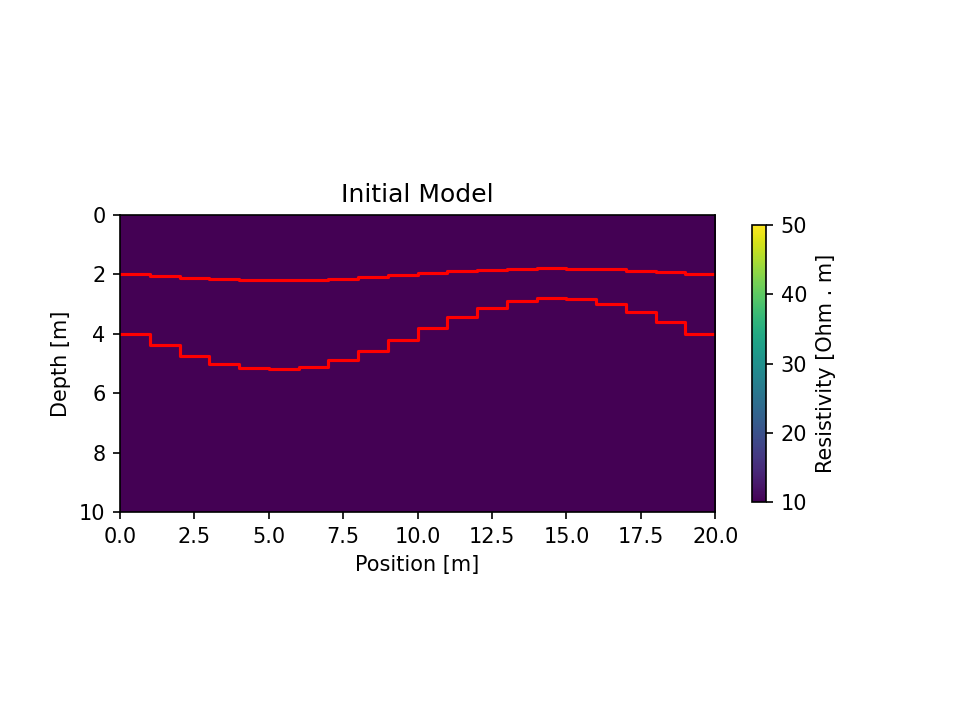

In [8]:
# Plot initial model

PlotResistivities(res_ini, npos, nlayer, 'Initial Model')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')

In [9]:
# Create forward modeller class

class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, res):
        surface = np.array([0])
        depthx = np.hstack((surface, depth[:-1]))
        res_air = np.array([2e14])
        resx = np.hstack((res_air, res))
        HCP = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        VCP = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        PRP = empymod.loop(Hsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        Z = np.hstack((HCP.real, HCP.imag, VCP.real, VCP.imag, PRP.real, PRP.imag))
        return Z
        
    def createStartModel(self, dataVals):
        
        res_ini = np.ones(nlayer)*10
        return res_ini

Set-up Inversion

In [10]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLogLU(1,1000)  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [11]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = res[i] # True model 
    model.append(model_i)
    data.append(EMf(model_i)) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [12]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=True, lam=1, maxIter=20, dPhi=0.01)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

07/10/22 - 14:46:54 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:46:54 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B58D7BB20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.9e-07/4.6e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 258.94 (dPhi = 22.97%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 52.98 (dPhi = 75.39%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 44.52 (dPhi = 13.06%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 32.21 (dPhi = 21.21%) lam: 1.0
--------------------------------------------------------------------------------
inv.ite

07/10/22 - 14:46:58 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:46:58 - pyGIMLi - INFO - Starting inversion.


chi² = 1.01 (dPhi = 0.01%) lam: 1.0
################################################################################
#                Abort criteria reached: dPhi = 0.01 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.6e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 344.09 (dPhi = 23.22%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 74.01 (dPhi = 75.3%) lam: 1.0
------------------------------------------------------------------------------

07/10/22 - 14:47:02 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:02 - pyGIMLi - INFO - Starting inversion.


chi² = 0.47 (dPhi = 58.12%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.47)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.7e-07/4.6e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 87.5 (dPhi = 78.17%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 71.41 (dPhi = 15.96%) lam: 1.0
----------------------------------------------------------------------------

07/10/22 - 14:47:07 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:07 - pyGIMLi - INFO - Starting inversion.


chi² = 1.02 (dPhi = 0.0%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -7.1e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 325.74 (dPhi = 16.85%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 259.36 (dPhi = 19.15%) lam: 1.0
-----------------------------------------------------------------------------

07/10/22 - 14:47:13 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:13 - pyGIMLi - INFO - Starting inversion.


chi² = 0.85 (dPhi = 1.15%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.85)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -7.1e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 411.16 (dPhi = 16.44%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 231.3 (dPhi = 42.25%) lam: 1.0
---------------------------------------------------------------------------

07/10/22 - 14:47:17 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:17 - pyGIMLi - INFO - Starting inversion.


chi² = 0.99 (dPhi = 0.08%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.99)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -7.2e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 429.49 (dPhi = 17.02%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 403.41 (dPhi = 5.53%) lam: 1.0
---------------------------------------------------------------------------

07/10/22 - 14:47:22 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:22 - pyGIMLi - INFO - Starting inversion.


chi² = 0.66 (dPhi = 2.76%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.66)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.8e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 376.35 (dPhi = 22.8%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 101.78 (dPhi = 70.06%) lam: 1.0
---------------------------------------------------------------------------

07/10/22 - 14:47:29 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:29 - pyGIMLi - INFO - Starting inversion.


chi² = 1.3 (dPhi = 0.01%) lam: 1.0
################################################################################
#                Abort criteria reached: dPhi = 0.01 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.8e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 246.8 (dPhi = 22.35%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 39.88 (dPhi = 78.83%) lam: 1.0
-------------------------------------------------------------------------------

07/10/22 - 14:47:35 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:35 - pyGIMLi - INFO - Starting inversion.


chi² = 1.12 (dPhi = 0.0%) lam: 1.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 0.01%)                 #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.6e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 257.21 (dPhi = 30.02%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 16.28 (dPhi = 88.69%) lam: 1.0
------------------------------------------------------------------------------

07/10/22 - 14:47:37 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:37 - pyGIMLi - INFO - Starting inversion.


chi² = 0.63 (dPhi = 20.0%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.63)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B59DAAB80>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -7.2e-07/4.6e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 384.43 (dPhi = 26.3%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 38.23 (dPhi = 86.79%) lam: 1.0
----------------------------------------------------------------------------

07/10/22 - 14:47:41 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:41 - pyGIMLi - INFO - Starting inversion.


chi² = 0.6 (dPhi = 12.25%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.60)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3B20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.7e-07/4.6e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 269.83 (dPhi = 35.08%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 12.88 (dPhi = 90.71%) lam: 1.0
---------------------------------------------------------------------------

07/10/22 - 14:47:45 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:45 - pyGIMLi - INFO - Starting inversion.


chi² = 0.96 (dPhi = 0.62%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.96)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3AC0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.4e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 182.86 (dPhi = 24.74%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 16.62 (dPhi = 84.9%) lam: 1.0
----------------------------------------------------------------------------

07/10/22 - 14:47:49 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:49 - pyGIMLi - INFO - Starting inversion.


chi² = 0.56 (dPhi = 24.39%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.56)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3BE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.0e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 134.79 (dPhi = 26.74%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 111.32 (dPhi = 16.24%) lam: 1.0
-------------------------------------------------------------------------

07/10/22 - 14:47:52 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:52 - pyGIMLi - INFO - Starting inversion.


chi² = 0.98 (dPhi = 5.59%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.98)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3B20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -5.6e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 10.64 (dPhi = 84.61%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 9.0 (dPhi = 7.72%) lam: 1.0
-------------------------------------------------------------------------------

07/10/22 - 14:47:56 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:56 - pyGIMLi - INFO - Starting inversion.


chi² = 0.73 (dPhi = 19.3%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.73)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3BE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -5.1e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.84 (dPhi = 87.8%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.58 (dPhi = 2.09%) lam: 1.0
--------------------------------------------------------------------------------

07/10/22 - 14:47:57 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:47:57 - pyGIMLi - INFO - Starting inversion.


chi² = 0.77 (dPhi = 5.42%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.77)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3B20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -5.6e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 6.55 (dPhi = 88.05%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 4.83 (dPhi = 9.48%) lam: 1.0
-------------------------------------------------------------------------------

07/10/22 - 14:48:00 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:48:00 - pyGIMLi - INFO - Starting inversion.


chi² = 0.69 (dPhi = 23.97%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.69)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3D60>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -5.5e-07/4.8e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 5.98 (dPhi = 89.88%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 4.27 (dPhi = 9.71%) lam: 1.0
------------------------------------------------------------------------------

07/10/22 - 14:48:02 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:48:02 - pyGIMLi - INFO - Starting inversion.


chi² = 0.73 (dPhi = 20.66%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.73)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3BE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -5.9e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 153.36 (dPhi = 22.19%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 21.66 (dPhi = 79.29%) lam: 1.0
--------------------------------------------------------------------------

07/10/22 - 14:48:06 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:48:06 - pyGIMLi - INFO - Starting inversion.


chi² = 0.91 (dPhi = 28.33%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3B20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -6.6e-07/4.6e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 233.02 (dPhi = 21.72%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 59.91 (dPhi = 70.15%) lam: 1.0
--------------------------------------------------------------------------

07/10/22 - 14:48:10 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
07/10/22 - 14:48:10 - pyGIMLi - INFO - Starting inversion.


chi² = 0.44 (dPhi = 13.5%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.44)                   #
################################################################################
fop: <__main__.EMforward object at 0x0000029B59B523B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000029B5A9B3D60>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000029B59B52310>
min/max (data): -7.1e-07/4.7e-06
min/max (error): 1%/1%
min/max (start model): 10/10
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 266.88 (dPhi = 20.74%) lam: 1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 101.03 (dPhi = 58.96%) lam: 1.0
--------------------------------------------------------------------------

<IPython.core.display.Javascript object>


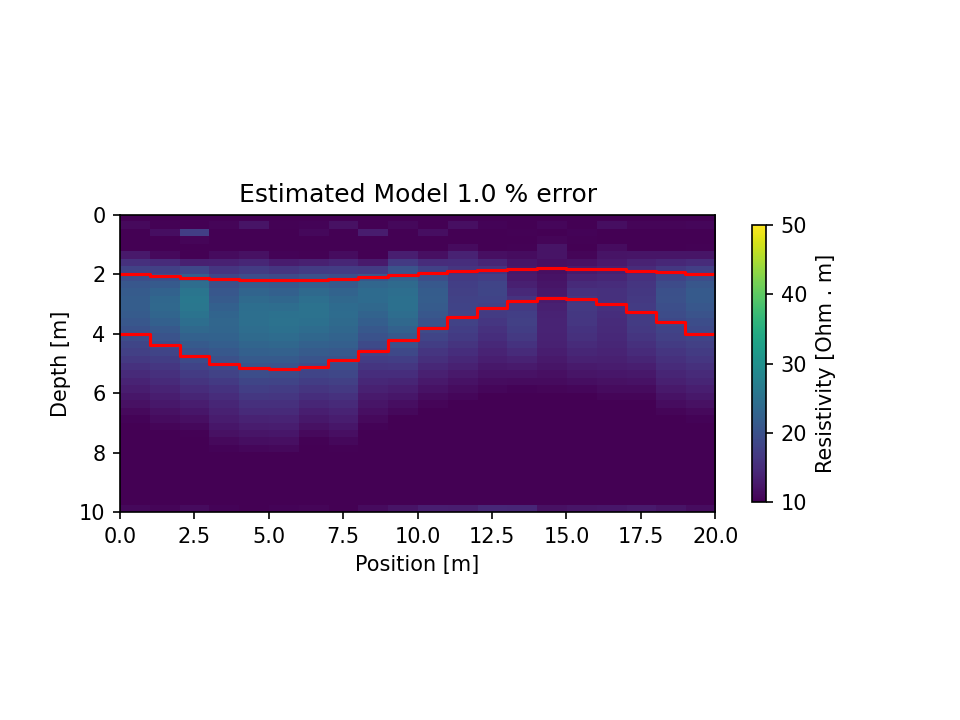

In [13]:
# Plot estimated model


PlotResistivities(model_est_arr, npos, nlayer, 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')